In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mind-institute-problematic-intern

In [2]:

# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Reload the train.csv file
train_path = '/kaggle/input/child-mind-institute-problematic-internet-use/train.csv'
train_df = pd.read_csv(train_path)

# Display general information about the dataset to confirm successful loading
train_info = train_df.info()
train_info



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

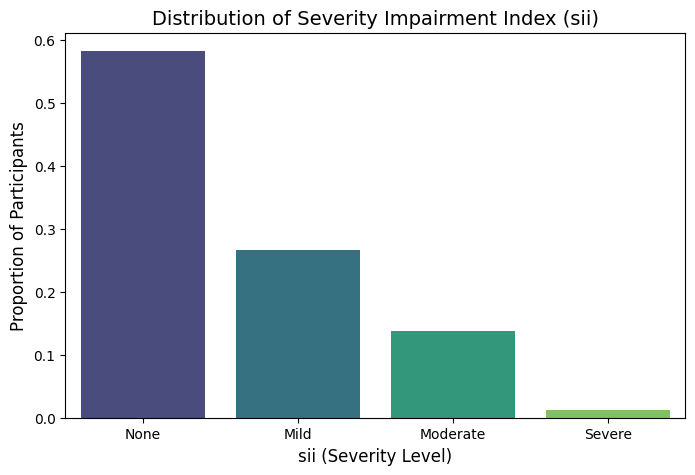

In [3]:
# Step 1: Distribution of the target variable (sii)
sii_distribution = train_df['sii'].value_counts(normalize=True).sort_index()

# Plot the distribution of 'sii'
plt.figure(figsize=(8, 5))
sns.barplot(x=sii_distribution.index, y=sii_distribution.values, palette='viridis')
plt.title('Distribution of Severity Impairment Index (sii)', fontsize=14)
plt.xlabel('sii (Severity Level)', fontsize=12)
plt.ylabel('Proportion of Participants', fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['None', 'Mild', 'Moderate', 'Severe'])
plt.show()

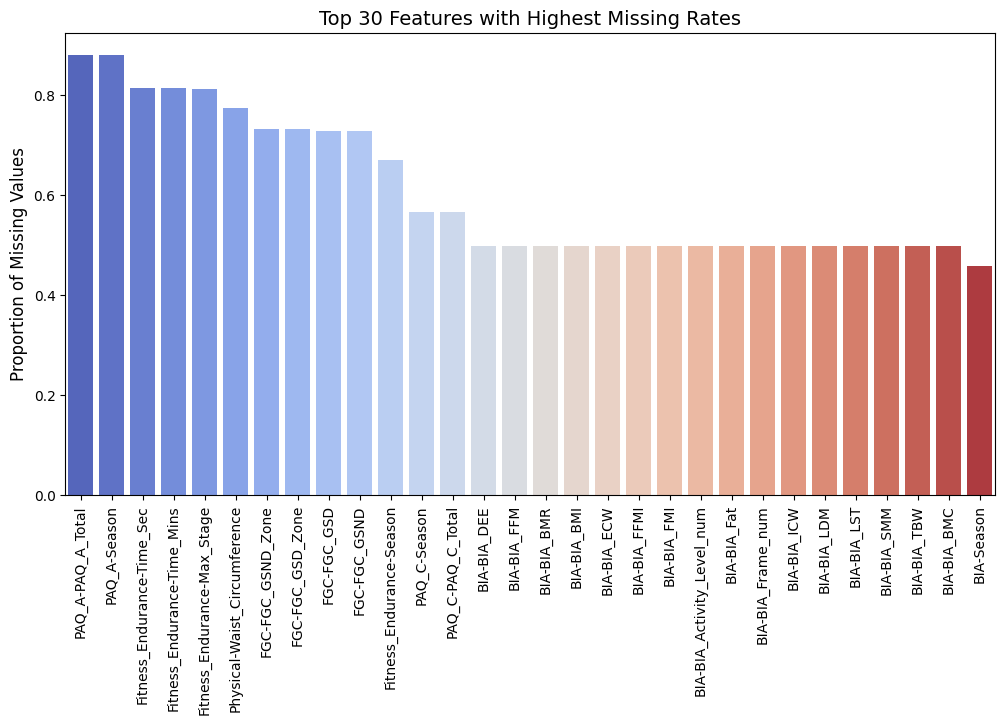

In [4]:

# Step 2: Missing data visualization
missing_data = train_df.isnull().mean().sort_values(ascending=False)

# Plot the missing data rates
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_data.index[:30], y=missing_data.values[:30], palette='coolwarm')
plt.title('Top 30 Features with Highest Missing Rates', fontsize=14)
plt.ylabel('Proportion of Missing Values', fontsize=12)
plt.xticks(rotation=90)
plt.show()





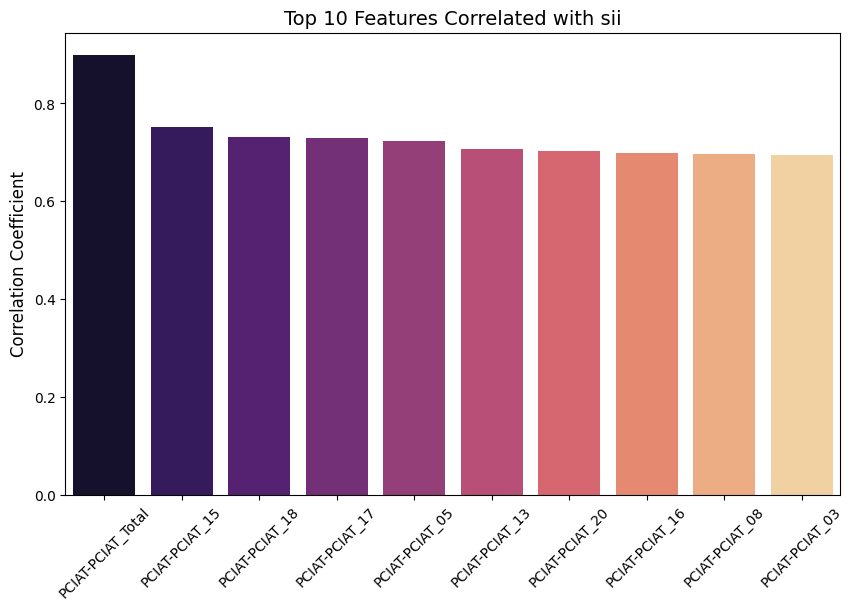

In [5]:

# Step 3: Correlation with sii
# Ensure 'id' and 'sii' are dropped only if they exist in the DataFrame
numeric_features = train_df.select_dtypes(include=['float64', 'int64']).copy()
columns_to_drop = [col for col in ['id', 'sii'] if col in numeric_features.columns]
numeric_features = numeric_features.drop(columns=columns_to_drop, errors='ignore')

# Compute correlations with 'sii' safely
correlations = numeric_features.corrwith(train_df['sii']).sort_values(ascending=False)

# Plot the top 10 correlations with 'sii'
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index[:10], y=correlations.values[:10], palette='magma')
plt.title('Top 10 Features Correlated with sii', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xticks(rotation=45)
plt.show()


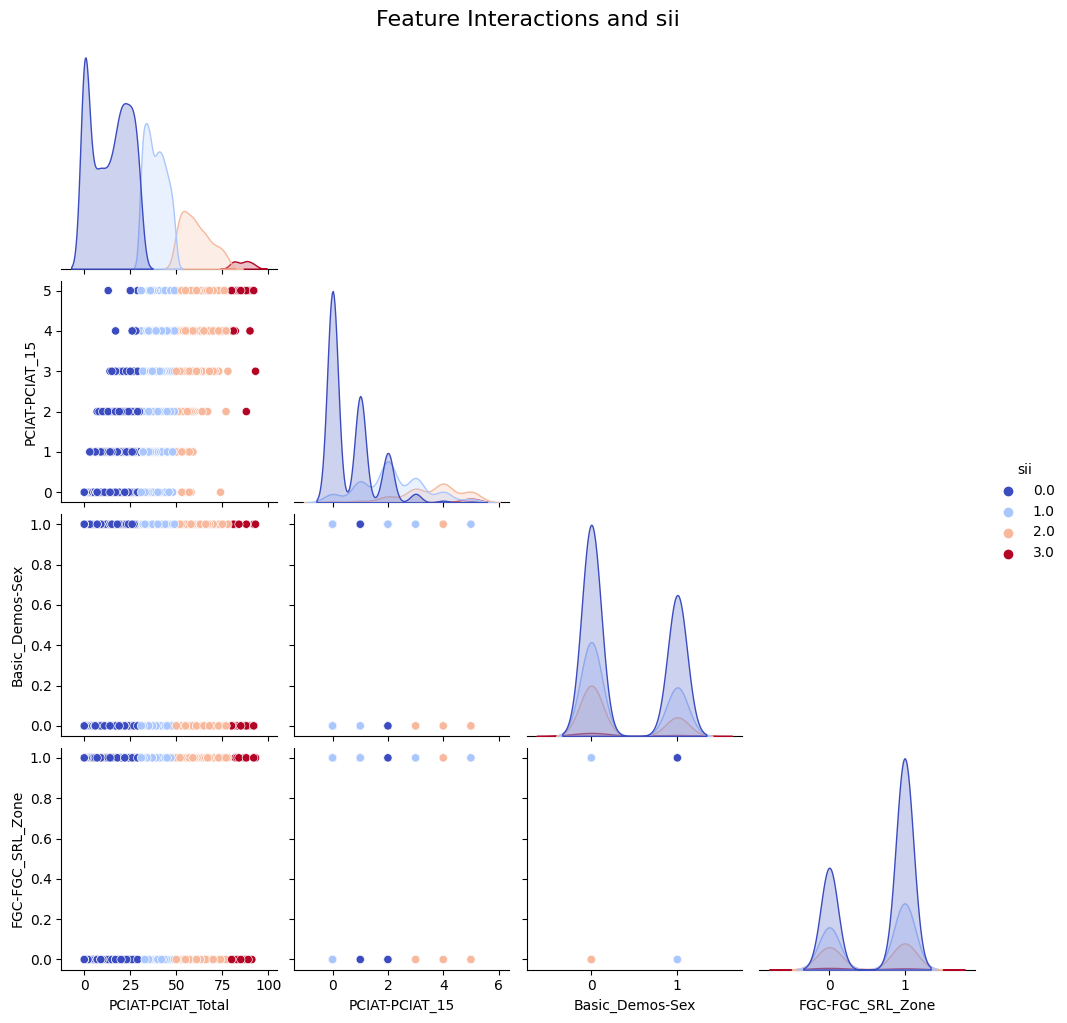

In [6]:

# Step 4: Advanced Insight - Feature Interaction Analysis
# Explore potential interactions between top correlated features
# Select the top 2 positively and negatively correlated features
positive_features = correlations.head(2).index.tolist()
negative_features = correlations.tail(2).index.tolist()
selected_features = positive_features + negative_features

# Pairplot to visualize potential interactions
sns.pairplot(train_df, vars=selected_features, hue='sii', palette='coolwarm', corner=True)
plt.suptitle('Feature Interactions and sii', y=1.02, fontsize=16)
plt.show()

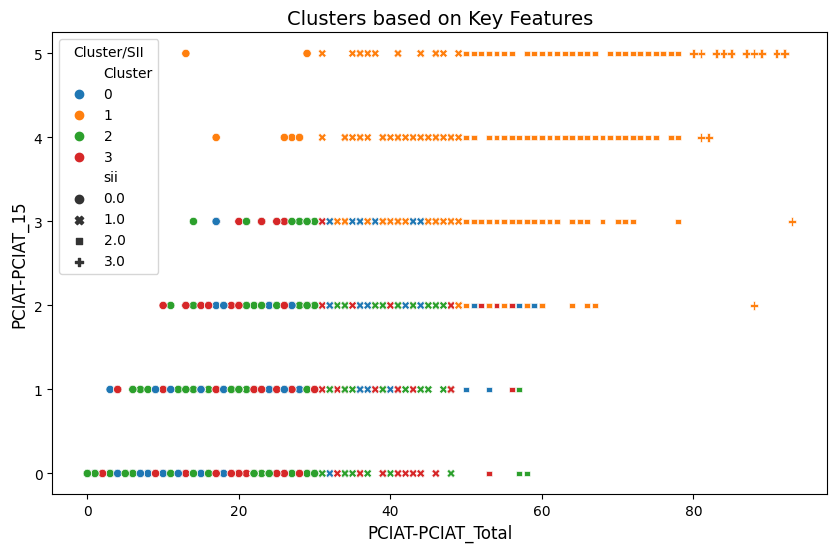

In [7]:
# Step 5: Advanced Insight - Clustering based on correlated features
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale the data for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features[selected_features].dropna())

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_clusters = kmeans.fit_predict(scaled_features)

# Add clusters to the dataset
clustered_data = train_df.dropna(subset=selected_features).copy()
clustered_data['Cluster'] = kmeans_clusters

# Visualize clusters with a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=clustered_data[selected_features[0]],
    y=clustered_data[selected_features[1]],
    hue=clustered_data['Cluster'],
    palette='tab10',
    style=clustered_data['sii']
)
plt.title('Clusters based on Key Features', fontsize=14)
plt.xlabel(selected_features[0], fontsize=12)
plt.ylabel(selected_features[1], fontsize=12)
plt.legend(title='Cluster/SII')
plt.show()



**Objective:**  
This notebook provides an in-depth exploratory data analysis (EDA) and advanced feature insights for the Child Mind Institute's Problematic Internet Use dataset. The aim is to uncover patterns and relationships between physical activity, demographic data, and the severity of internet use impairment (`sii`), enabling better understanding and preparation for predictive modeling.

---

**Structure of the Notebook:**

1. **Dataset Overview and Setup:**
   - Load and describe the dataset to understand its structure and key attributes.
   - Suppress unnecessary warnings to enhance readability.

2. **Exploratory Data Analysis (EDA):**
   - **Target Variable Analysis (`sii`):**
     - Examine the distribution of severity levels (`None`, `Mild`, `Moderate`, `Severe`) to assess balance and representation.
   - **Missing Data Exploration:**
     - Visualize missing data rates across features to prioritize data cleaning or imputation strategies.
   - **Correlation Analysis:**
     - Identify numerical features most strongly correlated (positively and negatively) with `sii`.

3. **Advanced Feature Insights:**
   - **Feature Interaction Analysis:**
     - Use pairplots to explore potential interactions between the most positively and negatively correlated features with `sii`.
   - **Clustering Analysis:**
     - Apply K-Means clustering on key correlated features to identify natural groupings within the data.
     - Visualize clusters with scatter plots, enhancing interpretability by combining cluster information with severity levels (`sii`).

4. **Key Insights and Visualizations:**
   - Use bar plots, pairplots, and scatter plots to communicate findings effectively.
   - Highlight actionable insights, such as clusters or feature relationships that could be critical for building predictive models.

---

**Highlights:**
- **Pairplot Analysis:** A focused look at feature interactions with the target variable.
- **Clustering:** Leverage unsupervised learning to reveal natural groupings and their overlap with `sii`.
- **Correlation Focus:** Pinpoint features with the strongest relationships to `sii` for modeling purposes.

---

**Applications:**
This notebook is a strong foundation for:
- Preparing data for machine learning pipelines.
- Feature engineering and selection.
- Gaining domain insights into problematic internet use behaviors.

Feel free to use and adapt this notebook to advance your analysis or improve prediction models. 🚀